In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, ndcg_score
import numpy as np

In [117]:
df = pd.read_csv('data_FraudDetection_JAR2020.csv')
df.head()
df = df.drop(['p_aaer'],axis =1)
df = df.dropna()
df['misstate'].value_counts()

0    125574
1       909
Name: misstate, dtype: int64

In [118]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(['misstate'],axis =1)  # Assuming you're only using 'Year' as a feature for simplicity
y = df['misstate']


# Split the data randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)  # Random state for reproducibility

In [119]:
# Convert splits back to DataFrame for easier manipulation
train_df = pd.DataFrame(X_train)
train_df['Fraud'] = y_train

test_df = pd.DataFrame(X_test)
test_df['Fraud'] = y_test

# Identify companies with fraud in both training and testing periods
# Assuming you have a 'Company' column to identify companies
train_fraud_companies = set(train_df[train_df['Fraud'] == 1]['gvkey'])
test_fraud_companies = set(test_df[test_df['Fraud'] == 1]['gvkey'])
serial_fraud_companies = train_fraud_companies.intersection(test_fraud_companies)

# Recode fraud in the training data for these serial fraud cases
train_df.loc[train_df['gvkey'].isin(serial_fraud_companies), 'Fraud'] = 0

train_df = train_df.drop(['gvkey'],axis =1) 
test_df = test_df.drop(['gvkey'],axis =1) 

In [120]:
from imblearn.over_sampling import SMOTE
X_train = train_df.drop(['Fraud'],axis =1)
y_train = train_df['Fraud']

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_test = test_df.drop(['Fraud'],axis =1)
y_test = test_df['Fraud']

In [121]:
X_test

,fyear,act,ap,at,ceq,che,cogs,csho,dlc,dltis,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
11599,1992,314.921,26.285,1274.464,774.169,42.323,197.512,55.815,210.398,60.157,...,0.225489,-0.202707,0.152254,-0.055020,1,2.641956,1.297608,-0.408580,0.017552,-0.070855
31901,1996,56.804,12.460,139.397,53.459,0.094,330.850,5.006,3.325,15.000,...,0.552178,0.217531,0.454069,-0.060719,1,0.938812,0.694949,0.290587,0.053731,-0.059068
100213,2006,16.496,1.773,20.610,15.789,11.937,7.683,26.075,0.000,0.000,...,0.374818,0.289629,-1.399360,0.118154,1,0.198532,1.282469,-1.404755,-0.710286,-0.351068
20424,1994,1005.634,195.108,2901.903,1732.602,307.548,1335.798,176.487,108.000,0.000,...,0.256429,0.246627,0.409182,0.065048,1,0.400701,0.986431,-0.149875,0.100102,-0.415357
119036,2010,229.792,93.486,312.398,148.104,80.145,502.481,23.023,1.267,0.000,...,0.658487,-0.022937,-0.051747,-0.182678,0,1.120709,0.987292,0.469331,-0.166410,0.001344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10630,1992,37.373,3.605,50.801,41.997,24.196,56.126,4.571,0.000,0.000,...,0.259385,0.253096,0.272378,0.025473,0,1.225027,0.933599,0.735084,0.045806,0.023183
43147,1997,1.851,1.316,27.012,4.561,1.768,2.413,5.532,1.287,3.073,...,0.896194,-0.670995,0.045644,-0.044022,1,0.879910,0.897844,-0.784984,-0.243188,-0.119189
105420,2007,44.691,3.338,95.179,69.021,7.686,39.983,36.103,2.228,0.583,...,0.571670,-0.115871,-0.518302,0.257904,1,0.326242,1.265113,-0.790868,0.143382,-0.377228
46982,1998,65.439,23.492,182.026,70.353,33.589,254.733,27.780,3.800,70.000,...,0.200872,-0.195466,0.294511,-0.003400,1,0.512912,0.906135,-0.384896,0.133431,0.046902


In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200]
}

# Make sure to include these base estimators in your imports if you haven't done so:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC (ensure to set probability=True for SVC)


In [100]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the classifier and parameter grid
classifier = RUSBoostClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring=make_scorer(f1_score))
grid_search.fit(X_train, y_train)

# Best model parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Evaluate the model using best parameters
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate predictions
from sklearn.metrics import recall_score, classification_report, confusion_matrix
print("Recall:", recall_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


from sklearn.metrics import roc_auc_score, ndcg_score
import numpy as np

probabilities = best_model.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, probabilities)
print(f"AUC: {auc_score}")

# NDCG@k Calculation (example with k=3)
sorted_indices = np.argsort(-probabilities)  # Indices sorted by descending probability
sorted_true_labels = y_test.values[sorted_indices]  # True labels sorted by predicted probabilities
ndcg_at_k = ndcg_score([sorted_true_labels[:3]], [probabilities[sorted_indices][:3]], k=3)
print(f"NDCG@3: {ndcg_at_k}")

Best Parameters:
{'n_estimators': 200}
Recall: 0.3296296296296296
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37675
           1       0.02      0.33      0.03       270

    accuracy                           0.87     37945
   macro avg       0.51      0.60      0.48     37945
weighted avg       0.99      0.87      0.92     37945

Confusion Matrix:
[[32945  4730]
 [  181    89]]
AUC: 0.6756743591634102
NDCG@3: 0.0


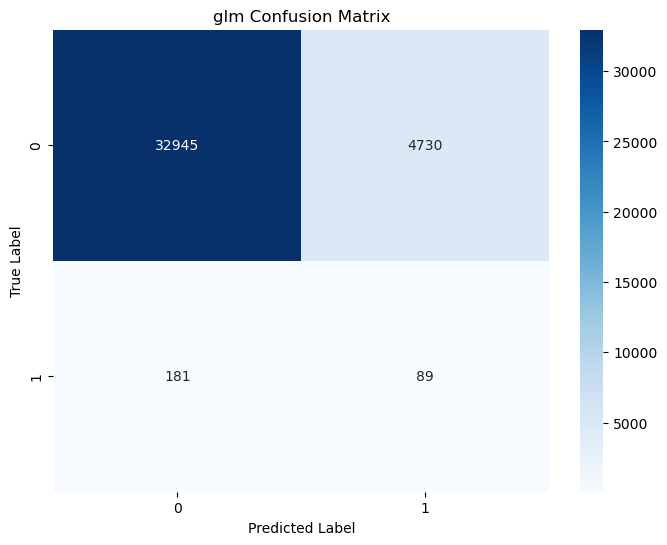

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns  # for a more advanced visualization
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(y_test, predictions, "RUSBoost Confusion Matrix")

In [114]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200,300],
    "scale_pos_weight": [1, 2],
    'min_child_weight': [1, 5, 10],
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up the grid search with cross-validation
grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)

# Fit the grid search model
grid_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Best Score for XGBoost:", grid_xgb.best_score_)

Best Parameters for XGBoost: {'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'scale_pos_weight': 2}
Best Score for XGBoost: 0.999897976534603


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37675
           1       0.03      0.05      0.04       270

    accuracy                           0.98     37945
   macro avg       0.51      0.52      0.51     37945
weighted avg       0.99      0.98      0.98     37945



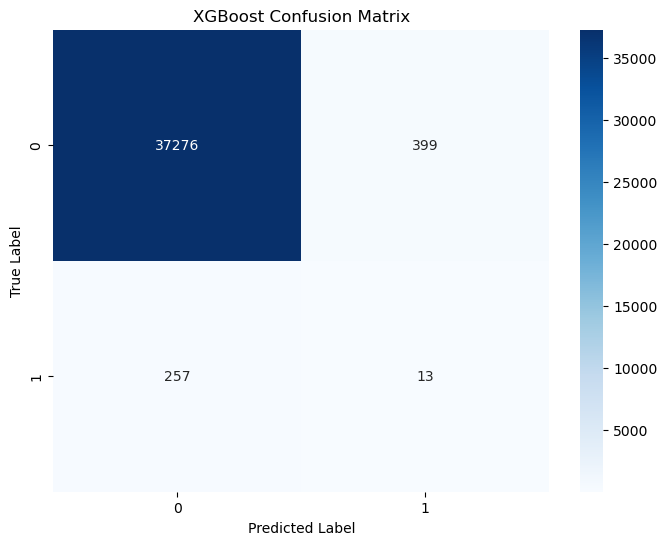

In [122]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions with the best models
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)

# Classification report
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

In [123]:
probabilities = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, probabilities)
print(f"AUC: {auc_score}")

# NDCG@k Calculation (example with k=3)
sorted_indices = np.argsort(-probabilities)  # Indices sorted by descending probability
sorted_true_labels = y_test.values[sorted_indices]  # True labels sorted by predicted probabilities
ndcg_at_k = ndcg_score([sorted_true_labels[:3]], [probabilities[sorted_indices][:3]], k=3)
print(f"NDCG@3: {ndcg_at_k}")

AUC: 0.6588367863550345
NDCG@3: 0.5


[23:37:47] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


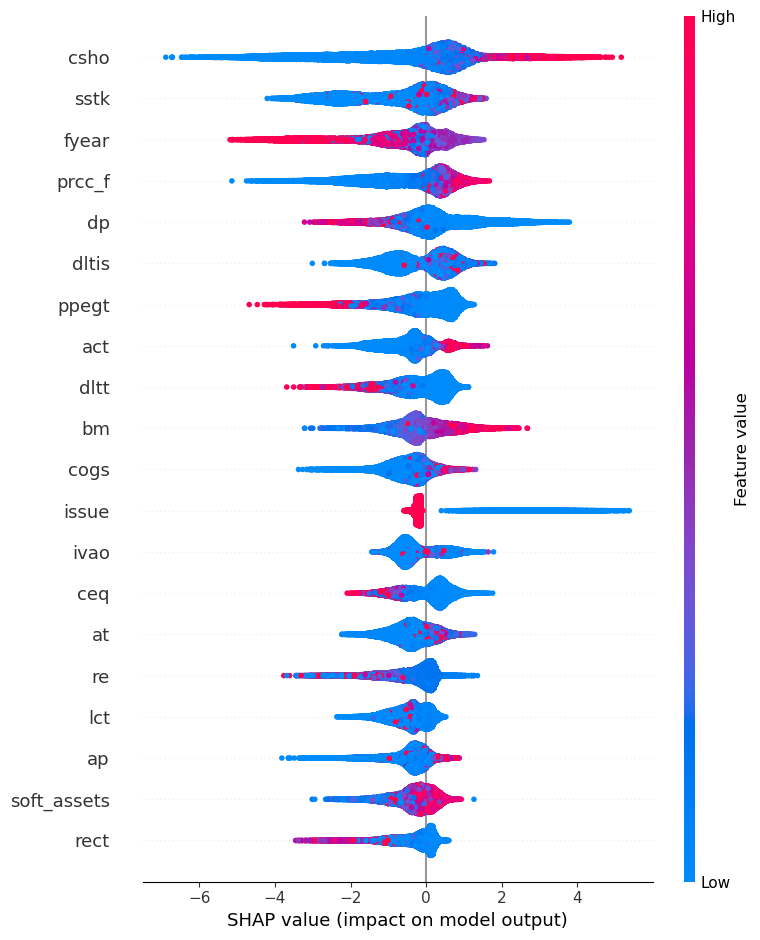

In [124]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(grid_xgb.best_estimator_)
shap_values = explainer(X_test)

# Plot summary plot using SHAP values
shap.summary_plot(shap_values, X_test)


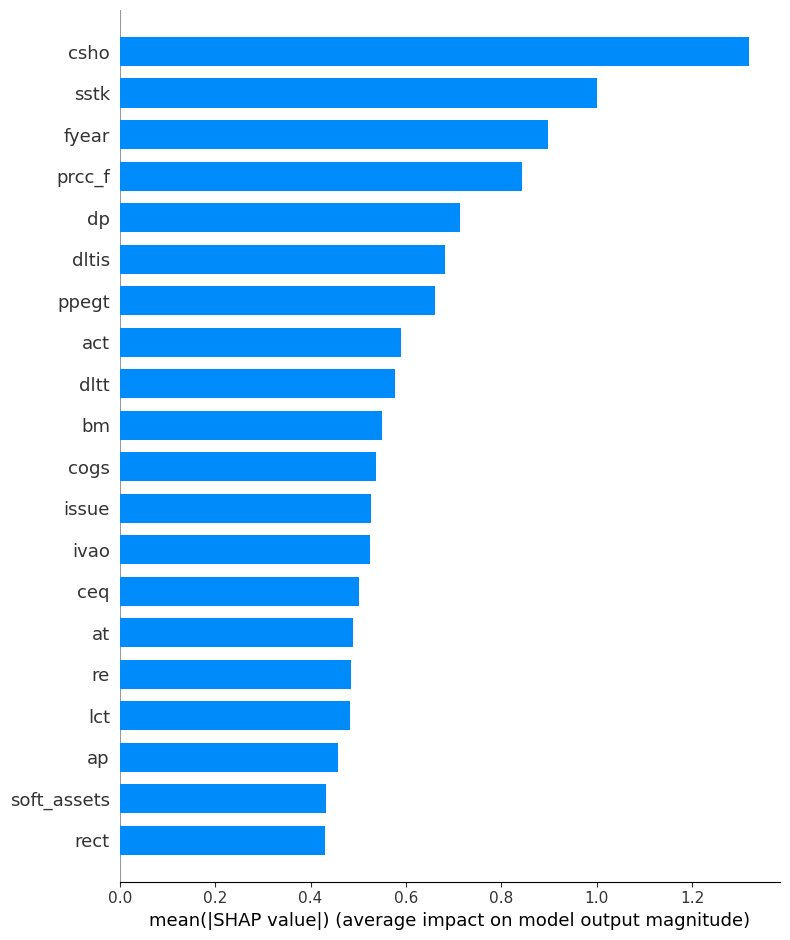

In [125]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


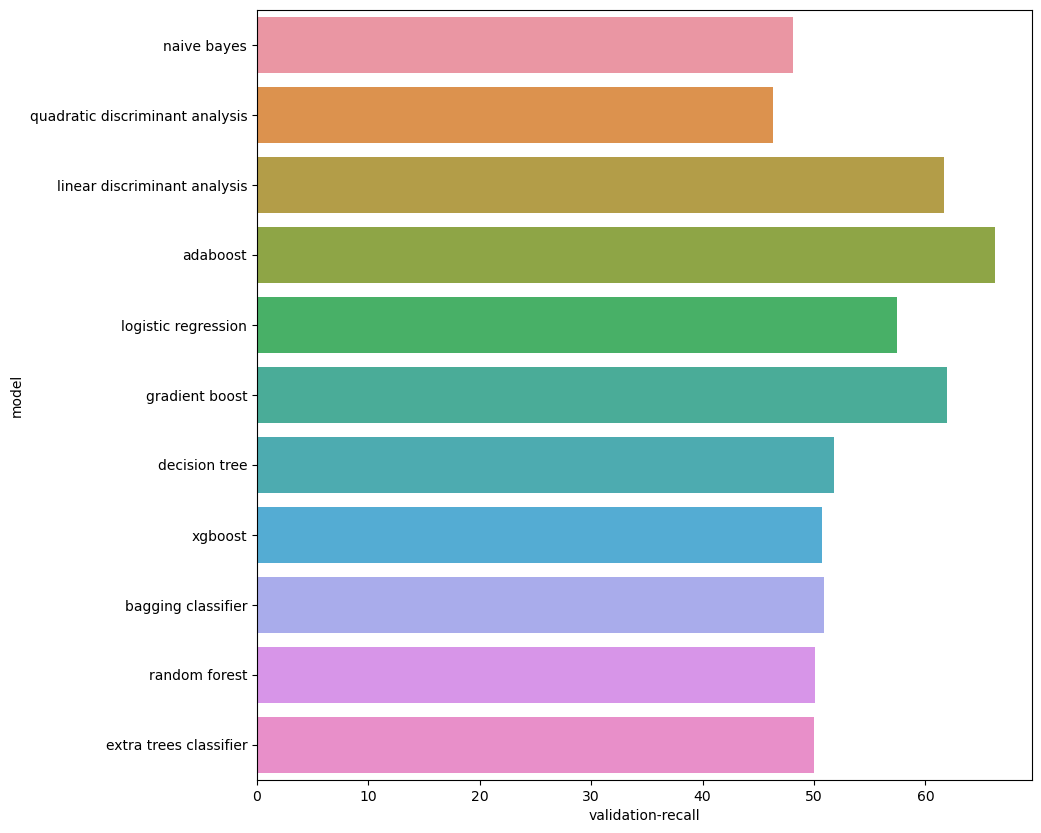

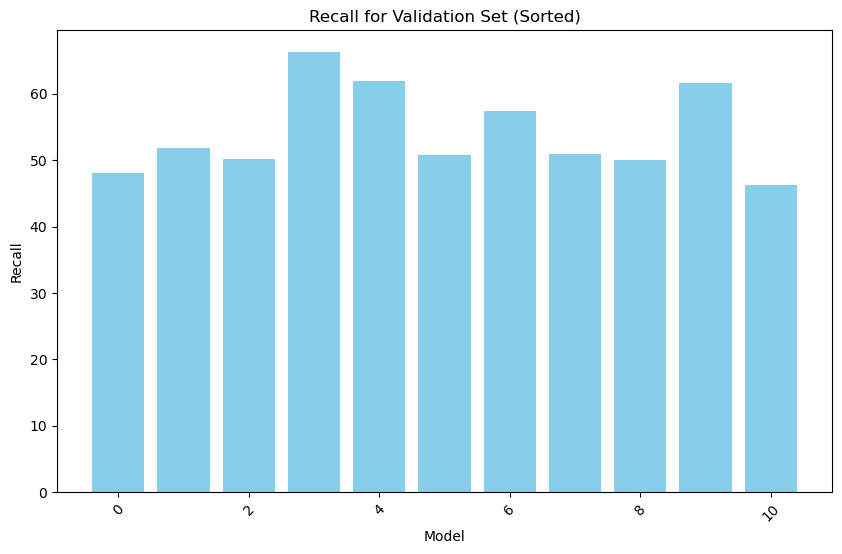

In [126]:
from AutoLogging_ML import AutoLogger
a,mode1=AutoLogger.train_and_log_classification(X_train, y_train, X_test, y_test,size='large')

aa = a[['model',"validation-accuracy","validation-precision","validation-recall","validation-f1","validation-confusion matrix"]]

sorted_df_desc = aa.sort_values(by='validation-recall', ascending=False)
sorted_df_desc

AutoLogger.get_metric_plot_classification(a,'validation','recall')

import matplotlib.pyplot as plt

# Assuming AutoLogger.get_metric_plot_classification() returns a dict with model names as keys and recall values as values
recall_data = a['validation-recall']

# Sort the recall data by values (recall scores)
# The sorted() function returns a list of tuples sorted by the second item in each tuple (the recall values here)
sorted_recall_data = sorted(recall_data.items(), key=lambda x: x[1], reverse=True)  # 'reverse=True' for descending order

# Unzip the sorted data into two lists: model names and their corresponding recall values
models, recalls = zip(*sorted_recall_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, recalls, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall for Validation Set (Sorted)')
plt.xticks(rotation=45)  # Rotate model names for better readability if necessary
plt.show()


In [129]:
sorted_df_desc

,model,validation-accuracy,validation-precision,validation-recall,validation-f1,validation-confusion matrix
3,adaboost,80.790618,50.738729,66.241073,46.502702,"[[30517, 7158], [131, 139]]"
4,gradient boost,85.803136,50.700987,61.962545,47.992869,"[[32456, 5219], [168, 102]]"
9,linear discriminant analysis,65.120569,50.362099,61.659343,40.543753,"[[24553, 13122], [113, 157]]"
6,logistic regression,84.108578,50.398543,57.432033,46.997932,"[[31833, 5842], [188, 82]]"
1,decision tree,97.306628,50.615996,51.759861,50.743047,"[[36908, 767], [255, 15]]"
7,bagging classifier,98.547898,50.837171,50.914080,50.873190,"[[37387, 288], [263, 7]]"
5,xgboost,98.511003,50.626489,50.711642,50.664760,"[[37374, 301], [264, 6]]"
2,random forest,99.183028,50.835623,50.130772,50.115427,"[[37634, 41], [269, 1]]"
8,extra trees classifier,99.280538,49.644194,49.996019,49.819485,"[[37672, 3], [270, 0]]"
0,naive bayes,13.735670,49.883419,48.101256,12.354122,"[[4988, 32687], [46, 224]]"


## Only contain 28 raw accounting variables

In [130]:
X_train1 = X_train.drop(columns=[
    'dch_wc',     # WC accruals
    'ch_rsst',    # RSST accruals
    'dch_rec',    # Change in receivables
    'dch_inv',    # Change in inventory
    'soft_assets',# % Soft assets
    'dpi',        # Depreciation index
    'ch_cs',      # Change in cash sales
    'ch_cm',      # Change in cash margin
    'ch_roa',     # Change in return on assets
    'ch_fcf',     # Change in free cash flows
    'reoa',       # Retained earnings over total assets
    'EBIT',       # Earnings before interest and taxes over total assets
    'issue',      # Actual issuance
    'bm'          # Book-to-market
])

X_test1 = X_test.drop(columns=[
    'dch_wc',     # WC accruals
    'ch_rsst',    # RSST accruals
    'dch_rec',    # Change in receivables
    'dch_inv',    # Change in inventory
    'soft_assets',# % Soft assets
    'dpi',        # Depreciation index
    'ch_cs',      # Change in cash sales
    'ch_cm',      # Change in cash margin
    'ch_roa',     # Change in return on assets
    'ch_fcf',     # Change in free cash flows
    'reoa',       # Retained earnings over total assets
    'EBIT',       # Earnings before interest and taxes over total assets
    'issue',      # Actual issuance
    'bm'          # Book-to-market
])

In [93]:
X_train.columns

Index(['fyear', 'gvkey', 'act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho',
       'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt',
       'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk', 'txp', 'txt',
       'xint', 'prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv',
       'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa',
       'EBIT', 'ch_fcf'],
      dtype='object')

In [131]:
from AutoLogging_ML import AutoLogger
a,mode1=AutoLogger.train_and_log_classification(X_train1, y_train, X_test1, y_test,size='large')

aa = a[['model',"validation-accuracy","validation-precision","validation-recall","validation-f1","validation-confusion matrix"]]

sorted_df_desc = aa.sort_values(by='validation-recall', ascending=False)
sorted_df_desc

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,validation-accuracy,validation-precision,validation-recall,validation-f1,validation-confusion matrix
3,adaboost,78.745553,50.511359,62.085625,45.501374,"[[29758, 7917], [148, 122]]"
4,gradient boost,83.992621,50.585850,61.050800,47.261968,"[[31769, 5906], [168, 102]]"
6,logistic regression,83.447094,50.368091,57.098921,46.750020,"[[31582, 6093], [188, 82]]"
9,linear discriminant analysis,56.729477,50.060506,52.101846,36.903730,"[[21398, 16277], [142, 128]]"
5,xgboost,98.134142,50.850181,51.441151,51.035854,"[[37226, 449], [259, 11]]"
1,decision tree,97.477929,50.217237,50.559119,50.183493,"[[36980, 695], [262, 8]]"
7,bagging classifier,98.545263,50.504267,50.545037,50.523282,"[[37388, 287], [265, 5]]"
2,random forest,99.185663,50.864668,50.132100,50.117122,"[[37635, 40], [269, 1]]"
8,extra trees classifier,99.267361,49.644147,49.989383,49.816167,"[[37667, 8], [270, 0]]"
0,naive bayes,7.352747,49.576183,46.173929,7.002700,"[[2559, 35116], [39, 231]]"


In [132]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the classifier and parameter grid
classifier = RUSBoostClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring=make_scorer(f1_score))
grid_search.fit(X_train1, y_train)

# Best model parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Evaluate the model using best parameters
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test1)

# Evaluate predictions
from sklearn.metrics import recall_score, classification_report, confusion_matrix
print("Recall:", recall_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


from sklearn.metrics import roc_auc_score, ndcg_score
import numpy as np

probabilities = best_model.predict_proba(X_test1)[:, 1] 

auc_score = roc_auc_score(y_test, probabilities)
print(f"AUC: {auc_score}")

# NDCG@k Calculation (example with k=3)
sorted_indices = np.argsort(-probabilities)  # Indices sorted by descending probability
sorted_true_labels = y_test.values[sorted_indices]  # True labels sorted by predicted probabilities
ndcg_at_k = ndcg_score([sorted_true_labels[:3]], [probabilities[sorted_indices][:3]], k=3)
print(f"NDCG@3: {ndcg_at_k}")

Best Parameters:
{'n_estimators': 200}
Recall: 0.3962962962962963
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     37675
           1       0.02      0.40      0.03       270

    accuracy                           0.84     37945
   macro avg       0.51      0.62      0.47     37945
weighted avg       0.99      0.84      0.91     37945

Confusion Matrix:
[[31856  5819]
 [  163   107]]
AUC: 0.678323084863231
NDCG@3: 0.0


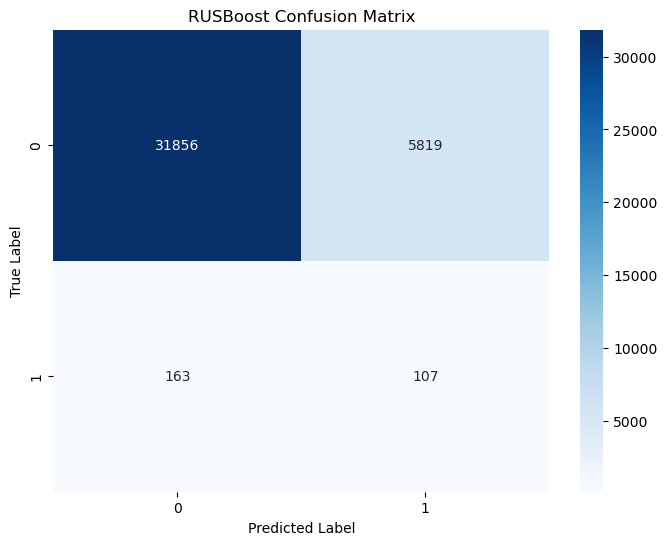

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns  # for a more advanced visualization
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(y_test, predictions, "RUSBoost Confusion Matrix")

In [139]:
# Define the model
gbm = GradientBoostingClassifier(random_state=42)

# Fit the grid search to the data
gbm.fit(X_train1, y_train)

AttributeError: 'GradientBoostingClassifier' object has no attribute 'best_estimator_'

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37675
           1       0.02      0.38      0.03       270

    accuracy                           0.84     37945
   macro avg       0.51      0.61      0.47     37945
weighted avg       0.99      0.84      0.91     37945



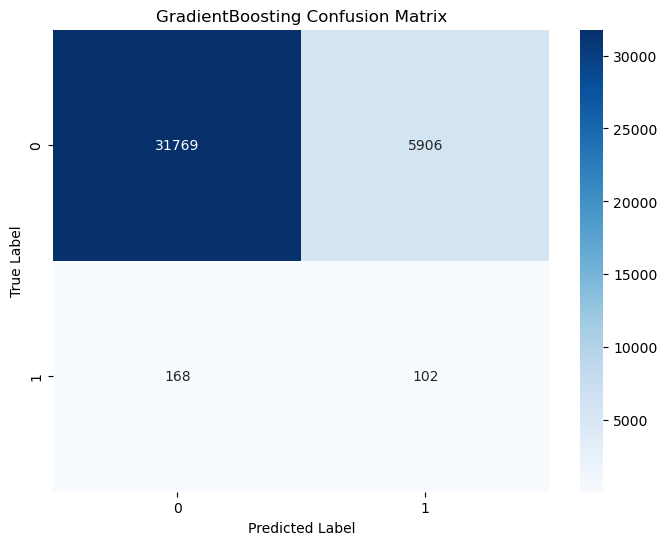

AUC: 0.7113607608936076
NDCG@3: 0.5


In [141]:
y_pred = gbm.predict(X_test1)
print(classification_report(y_test, y_pred))

# Plotting confusion matrices
plot_confusion_matrix(y_test, y_pred, "GradientBoosting Confusion Matrix")

probabilities = gbm.predict_proba(X_test1)[:, 1] 

auc_score = roc_auc_score(y_test, probabilities)
print(f"AUC: {auc_score}")

# NDCG@k Calculation (example with k=3)
sorted_indices = np.argsort(-probabilities)  # Indices sorted by descending probability
sorted_true_labels = y_test.values[sorted_indices]  # True labels sorted by predicted probabilities
ndcg_at_k = ndcg_score([sorted_true_labels[:3]], [probabilities[sorted_indices][:3]], k=3)
print(f"NDCG@3: {ndcg_at_k}")

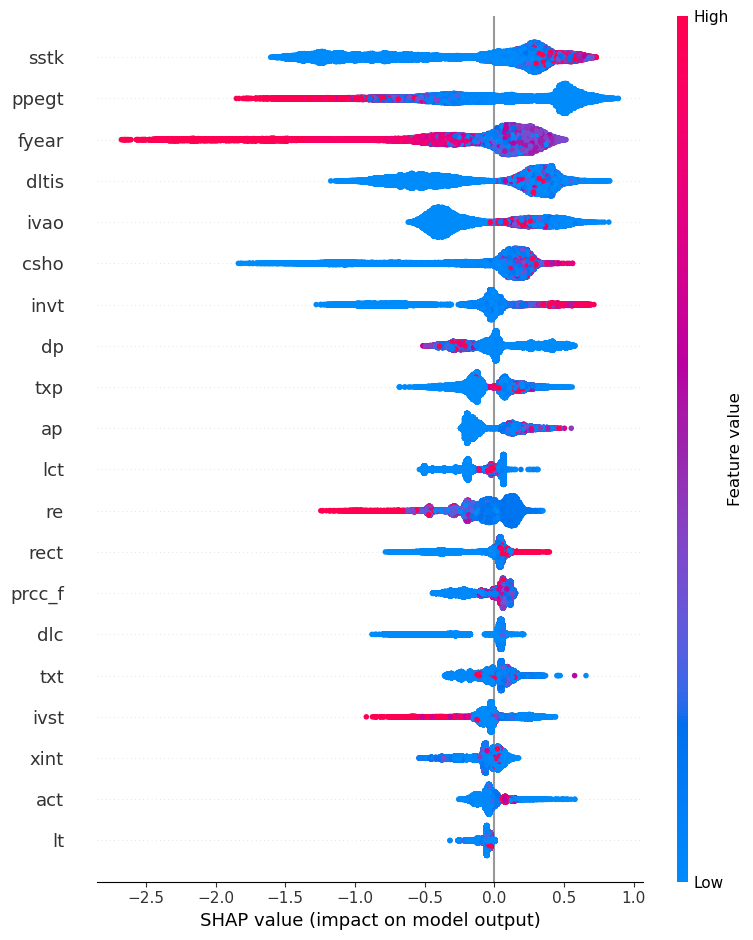

In [142]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(gbm)
shap_values = explainer(X_test1)

# Plot summary plot using SHAP values
shap.summary_plot(shap_values, X_test1)


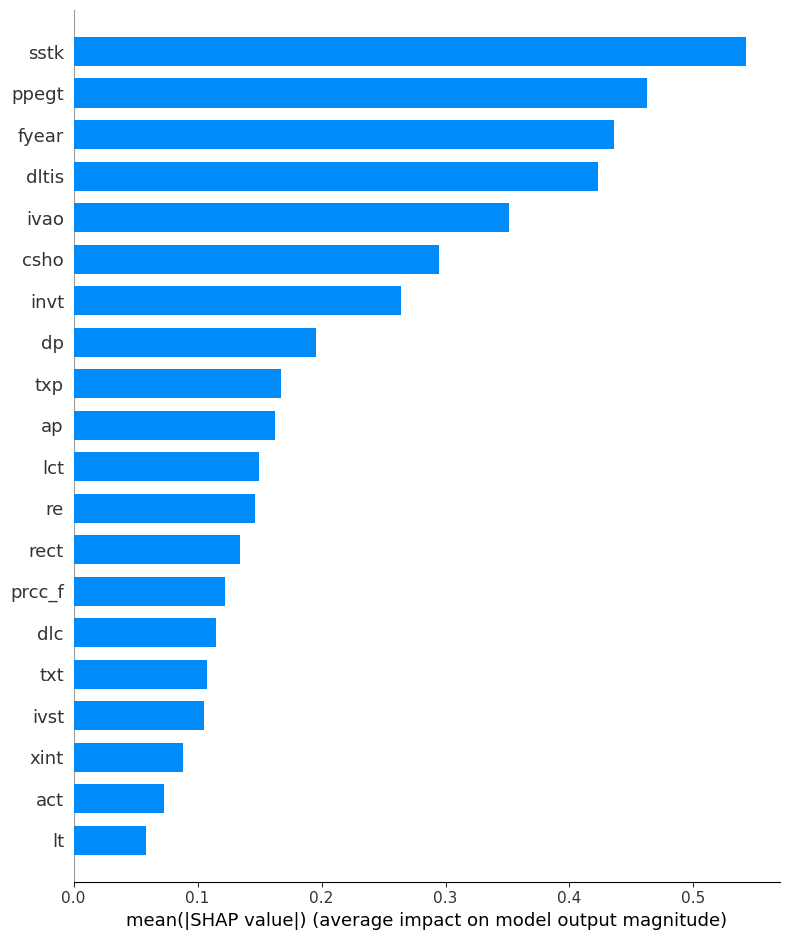

In [143]:
shap.summary_plot(shap_values, X_test1, plot_type="bar")